# Flare Frequency Distributions, power laws, and more

## This notebook illustrates the use of the FFD module `ffd.py`. 

FFD stands for Flare Frequency Distribution. The format of the flare table that is used to inititalize an FFD object shares some of the columns of the `FlareLightCurve.flares` table. 

## This module includes functionality to 

- fit the power law exponent $\alpha$ and intercept $\beta$, 
- plot the resulting function in the cumulative form,
- test if the power law assumption must be rejected, 
- and if the distribution is truncated at the high energy end.

Furthermore, you can make use of the `ed_corr`, `recovery_probability` attributes of the flares in the flare table that you may obtain from performing *injection and recovery of synthetic flares*.

Finally, if your flare table contains contributions from multiple stars that you think generate flares that can be described by the same power law but with different detection thresholds, you can use the `mutliple_stars` keyword to account for this. 

*Note that samples with less than 100-200 flares are to be analysed with caution.*

In [1]:
# Import the main class and a function to generate synthetic flare samples.
from altaipony.ffd import FFD, generate_random_power_law_distribution

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 16

## Create an FFD object

Flares appear to follow a power law distribution of energies like so:

$$f(E)\,\mathrm{d}E = \beta \cdot E^{-\alpha}\,\mathrm{d}E$$

Let's create a power law distributed sample of flare energies with exponent $\alpha=-2$

A simple FFD of only one star where we assume to have correct energies, no observational biases, and a clear detection threshold at $ED=10$ s.

`ed_rec` is the recovered equivalent duration of the flare.

In [2]:
# a, b, g, size = energy lower and upper limit, power law exponent +1, number of flares
pwl = generate_random_power_law_distribution(10, 1e3, -1, size=200, seed=80)

# Create a FFD with the energies you detected. 
simple_ffd = FFD(f=pd.DataFrame({"ed_rec": pwl}))
simple_ffd.f.head()

No total observing time given. Set to 1. You are now working with number counts instead of frequency.


,ed_rec
0,20.690935
1,32.511053
2,13.645735
3,30.096645
4,99.001434


In [3]:
# The default value for the total observing time 
# that it took to detect the candidates im simple_ffd.f
# is set to 1.
simple_ffd.tot_obs_time

1.0

## Plot the FFD

In [4]:
ed, freq, counts = simple_ffd.ed_and_freq()

Setting ED with new values, size 200.
Setting frequency values with new values, size 200.
Setting frequency adjusted count values with new values, size 200.


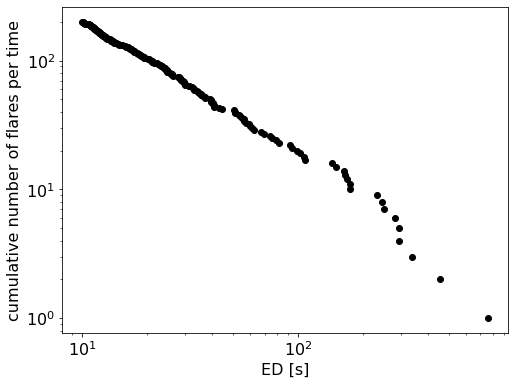

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(ed, freq, c="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time");

## Fit powerlaw

We can fit the power law exponent $\alpha$ and intercept $\beta$ using `FFD.fit_powerlaw()`

This method is detailed in [Ilin et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv201005576I/abstract), and implements a simplified version of the Bayesian flare frequency predictor developed by Wheatland (2004).

In [6]:
# Caution: may take a minute
simple_ffd.fit_powerlaw("mcmc");

100%|██████████| 500/500 [00:06<00:00, 79.96it/s]


In [7]:
# power law exponent (see Eq. 3 in Ilin et al. (2020))
simple_ffd.alpha, simple_ffd.alpha_up_err, simple_ffd.alpha_low_err

(2.041785081531872, 0.07598158206969874, 0.07111524587912488)

In [8]:
# power law intercept  (see Eq. 3 in Ilin et al. (2020))
simple_ffd.beta, simple_ffd.beta_up_err,  simple_ffd.beta_low_err, 

(2302.96755340424, 670.4364587925747, 503.09507205326236)

## Plot the power law

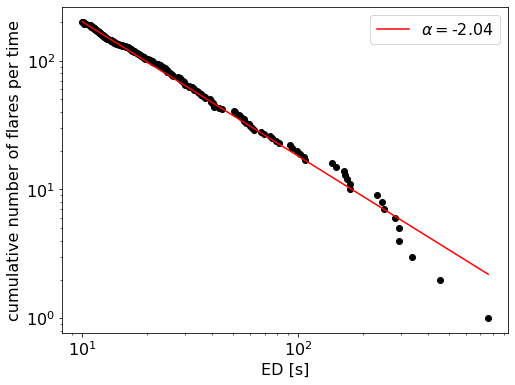

In [9]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.scatter(ed, freq, c="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
simple_ffd.plot_powerlaw(ax, c="r", label=fr'$\alpha=$-{simple_ffd.alpha:.2f}')
plt.legend();

## Is this distribution a powerlaw?

In [10]:
simple_ffd.is_powerlaw()

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-1.0.0-py3.6.egg/altaipony/ffd.py:506: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


True

## Is this power law distribution truncated at the upper energy limit?

In [11]:
simple_ffd.is_powerlaw_truncated()

False

This distribution is consistent with a power law that is not truncated.

Let's create a truncated version and see if it works:

In [12]:
f=pd.DataFrame({"ed_rec": pwl})
simple_truncated_ffd = FFD(f=f[f.ed_rec < 200])  # truncate at 200s 
simple_truncated_ffd.alpha = 2.
simple_truncated_ffd.ed_and_freq();

No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 191.
Setting frequency values with new values, size 191.
Setting frequency adjusted count values with new values, size 191.


In [13]:
simple_truncated_ffd.is_powerlaw_truncated()

True

*You can play with the truncation limit and sample size to get a feeling for the sensitivity of the test given the sample size.*

# Fit $\alpha$ using the MLE method from Maschberger and Kroupa (2009).

Alternatively, you can fit $\alpha$ and $\beta$ using a modified maximum likelihood estimator for $\alpha$ and a least suqares fit with bootstrapped uncertainties on $\beta$.

You can use it by passing "mmle" to `fit_powerlaw()`

In general, we recommend to use the MCMC fit we used above, because it fits both uncertainties simultaneously and more accurately if the posterior distribution is asymmteric (which is typically the case), but if you just want a relatively quick estimate of the parameter, the MMLE is your friend.  

See Maschberger and Kroupa (2009) for details: [MNRAS](https://academic.oup.com/mnras/article/395/2/931/1747409), [ArXiv](https://arxiv.org/abs/0905.0474)

In [14]:
simple_ffd.fit_powerlaw("mmle")
simple_ffd.alpha, simple_ffd.alpha_err

(1.963553855895996, 0.08012203082491737)

$\beta$ is fitted using the least-squares method:

In [15]:
simple_ffd.beta, simple_ffd.beta_err

(1753.1677389526367, 140.50464845948764)

Finally, show the resulting fit, and compare to the intrinsic distribution:

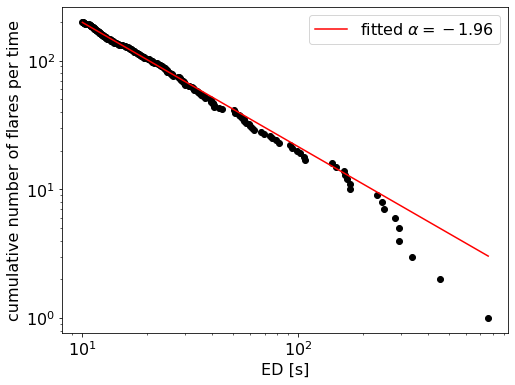

In [16]:
fig, ax = plt.subplots(1, figsize=(8,6))

# Plot the FFD together with the best fit power law

ax.scatter(simple_ffd.ed, simple_ffd.freq, c="k")
simple_ffd.plot_powerlaw(ax, c="r", label=fr"fitted $\alpha=-{simple_ffd.alpha:.2f}$")

#--------------------------------------------------------------------------------------

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time")
plt.legend();